In [2]:
import pystan
%matplotlib inline

ImportError: No module named 'pystan'

In [2]:
schools_code = """
data {
    int<lower=0> J; // number of schools
    real y[J]; // estimated treatment effects
    real<lower=0> sigma[J]; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    real eta[J];
}
transformed parameters {
    real theta[J];
    for (j in 1:J)
    theta[j] <- mu + tau * eta[j];
}
model {
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

fit = pystan.stan(model_code=schools_code, data=schools_dat,
                  iter=1000, chains=4)

CompileError: command 'C:\\Users\\KiraPc\\Anaconda\\Scripts\\gcc.bat' failed with exit status 1

In [3]:
print(fit)

Inference for Stan model: anon_model_95013624776d537c3cd7cd4d641c30e0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         8.05    0.27   5.25  -2.27   4.82   8.07  11.26  18.92  369.0   1.01
tau        6.32    0.28   5.09   0.29   2.59   5.09   8.79  18.33  336.0    1.0
eta[0]      0.4    0.04   0.94  -1.54  -0.19    0.4   1.03   2.21  590.0    1.0
eta[1]    -0.03    0.04   0.87  -1.78   -0.6  -0.04   0.58   1.66  595.0    1.0
eta[2]    -0.18    0.04   0.94  -1.97  -0.82  -0.22   0.45   1.69  619.0    1.0
eta[3]    -0.07    0.04   0.95  -1.93  -0.72  -0.08   0.57   1.81  584.0    1.0
eta[4]    -0.34    0.04   0.89  -2.04  -0.92   -0.4   0.25   1.49  564.0    1.0
eta[5]    -0.26    0.04   0.89  -1.91  -0.85  -0.29    0.3   1.65  578.0   1.01
eta[6]     0.33    0.04    0.9  -1.47  -0.28   0.35   0.95   2.08  612.0    1.0
eta[7]     0.

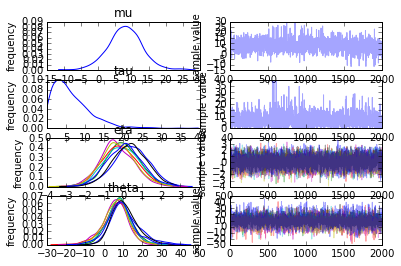

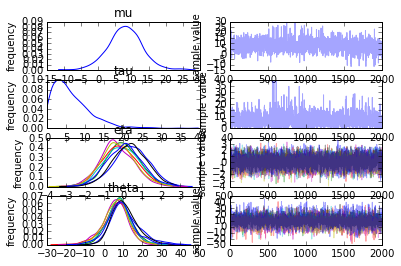

In [6]:
fit.plot()

In [7]:
corr_lda_code = """
data {
  int<lower=2> K;               // num topics
  int<lower=2> V;               // num words
  int<lower=1> M;               // num docs
  int<lower=1> N;               // total word instances
  int<lower=1,upper=V> w[N];    // word n
  int<lower=1,upper=M> doc[N];  // doc ID for word n
  vector<lower=0>[V] beta;      // word prior
  //*** Topic prior alpha is gone ***//
}
parameters {
  //*** Instead you sample topic proportions from a Gaussain*** 
  vector[K] mu;              // topic mean
  corr_matrix[K] Omega;      // correlation matrix
  // ********
  vector<lower=0>[K] sigma;  // scales
  vector[K] eta[M];           // logit topic dist for doc m
  simplex[V] phi[K];         // word dist for topic k
}
transformed parameters {
  simplex[K] theta[M];       // simplex topic dist for doc m
  cov_matrix[K] Sigma;       // covariance matrix
  for (m in 1:M)
    theta[m] <- softmax(eta[m]);
  for (m in 1:K) {
    Sigma[m,m] <- sigma[m] * sigma[m] * Omega[m,m];
    for (n in (m+1):K) {
      Sigma[m,n] <- sigma[m] * sigma[n] * Omega[m,n];
      Sigma[n,m] <- Sigma[m,n];
    }
  } 
}
model {
  // priors
  for (k in 1:K)  
    phi[k] ~ dirichlet(beta);
  mu ~ normal(0,5);
  Omega ~ lkj_corr(2.0);
  sigma ~ cauchy(0,5);
  // topic distribution for docs
  for (m in 1:M)
    eta[m] ~ multi_normal(mu,Sigma);
  // token probabilities
  for (n in 1:N) {
    real gamma[K];
    for (k in 1:K) 
      gamma[k] <- log(theta[doc[n],k]) + log(phi[k,w[n]]);
    increment_log_prob(log_sum_exp(gamma));  // likelihood
  }
}
"""

In [2]:
lda_code = """
data {
  int<lower=2> K;               // num topics
  int<lower=2> V;               // num words (distinct)
  int<lower=1> M;               // num docs
  int<lower=1> N;               // total word instances
  int<lower=1,upper=V> w[N];    // word n
  int<lower=1,upper=M> doc[N];  // doc ID for word n
  vector<lower=0>[K] alpha;     // topic prior
  vector<lower=0>[V] beta;      // word prior
}
parameters {
  simplex[K] theta[M];   // topic dist for doc m
  simplex[V] phi[K];     // word dist for topic k
}
model {
  for (m in 1:M)  
    theta[m] ~ dirichlet(alpha);  // prior
  for (k in 1:K)  
    phi[k] ~ dirichlet(beta);     // prior
  for (n in 1:N) {
    real gamma[K];
    for (k in 1:K) 
      gamma[k] <- log(theta[doc[n],k]) + log(phi[k,w[n]]);
    increment_log_prob(log_sum_exp(gamma));  // likelihood
  }
}
"""

In [9]:
lda_data = {'K':2,'V':5,'M':25,'N':262,
'w': [4L, 3L, 5L, 4L, 3L, 3L, 3L, 3L, 3L, 4L, 5L, 3L, 4L, 4L, 5L, 
3L, 4L, 4L, 4L, 3L, 5L, 4L, 5L, 2L, 3L, 3L, 1L, 5L, 5L, 1L, 4L, 
3L, 1L, 2L, 5L, 4L, 4L, 3L, 5L, 4L, 2L, 4L, 5L, 3L, 4L, 1L, 4L, 
4L, 3L, 2L, 1L, 2L, 1L, 2L, 2L, 2L, 1L, 2L, 2L, 3L, 1L, 2L, 2L, 
4L, 4L, 5L, 4L, 5L, 5L, 4L, 3L, 5L, 4L, 4L, 4L, 2L, 2L, 1L, 1L, 
2L, 1L, 3L, 1L, 2L, 1L, 1L, 1L, 3L, 2L, 3L, 3L, 5L, 4L, 5L, 4L, 
3L, 5L, 4L, 2L, 2L, 2L, 1L, 3L, 2L, 1L, 3L, 1L, 3L, 1L, 1L, 2L, 
1L, 2L, 2L, 4L, 4L, 4L, 5L, 5L, 4L, 4L, 5L, 4L, 3L, 3L, 3L, 1L, 
3L, 3L, 4L, 2L, 1L, 3L, 4L, 4L, 5L, 4L, 4L, 4L, 3L, 4L, 3L, 4L, 
5L, 1L, 2L, 1L, 3L, 2L, 1L, 1L, 2L, 3L, 3L, 3L, 3L, 4L, 1L, 4L, 
4L, 4L, 4L, 3L, 4L, 4L, 1L, 2L, 2L, 3L, 3L, 1L, 1L, 4L, 1L, 3L, 
1L, 5L, 3L, 2L, 2L, 1L, 1L, 2L, 3L, 3L, 4L, 4L, 5L, 3L, 4L, 3L, 
1L, 5L, 5L, 5L, 3L, 3L, 4L, 5L, 3L, 3L, 3L, 2L, 3L, 1L, 3L, 3L, 
1L, 3L, 1L, 5L, 5L, 5L, 2L, 2L, 3L, 3L, 3L, 1L, 1L, 5L, 5L, 5L, 
3L, 1L, 5L, 4L, 1L, 3L, 3L, 3L, 3L, 4L, 2L, 5L, 1L, 3L, 5L, 2L, 
5L, 5L, 2L, 1L, 3L, 3L, 5L, 3L, 5L, 3L, 3L, 5L, 1L, 2L, 2L, 1L, 
1L, 2L, 1L, 2L, 3L, 1L, 1L],
'doc': [1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 2L, 2L, 2L, 2L, 
2L, 2L, 2L, 2L, 2L, 2L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 
3L, 3L, 3L, 3L, 3L, 3L, 3L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 
4L, 4L, 4L, 4L, 4L, 5L, 5L, 5L, 5L, 5L, 5L, 5L, 5L, 5L, 5L, 5L, 
6L, 6L, 6L, 6L, 6L, 6L, 6L, 7L, 7L, 7L, 7L, 7L, 8L, 8L, 8L, 8L, 
8L, 8L, 8L, 8L, 8L, 8L, 8L, 8L, 8L, 8L, 8L, 8L, 9L, 9L, 9L, 9L, 
9L, 9L, 9L, 10L, 10L, 10L, 10L, 10L, 10L, 10L, 10L, 10L, 10L, 
10L, 10L, 10L, 10L, 10L, 10L, 11L, 11L, 11L, 11L, 11L, 11L, 12L, 
12L, 12L, 12L, 13L, 13L, 13L, 13L, 13L, 13L, 13L, 13L, 13L, 14L, 
14L, 14L, 14L, 14L, 14L, 14L, 14L, 14L, 14L, 14L, 15L, 15L, 15L, 
15L, 15L, 15L, 15L, 15L, 15L, 15L, 15L, 16L, 16L, 16L, 16L, 16L, 
16L, 16L, 16L, 16L, 16L, 17L, 17L, 17L, 17L, 17L, 17L, 17L, 17L, 
17L, 18L, 18L, 18L, 18L, 18L, 18L, 18L, 18L, 18L, 18L, 19L, 19L, 
19L, 19L, 19L, 19L, 19L, 19L, 19L, 20L, 20L, 20L, 20L, 20L, 20L, 
20L, 20L, 20L, 21L, 21L, 21L, 21L, 21L, 21L, 21L, 21L, 21L, 21L, 
22L, 22L, 22L, 22L, 22L, 22L, 22L, 22L, 23L, 23L, 23L, 23L, 23L, 
23L, 23L, 23L, 23L, 23L, 24L, 24L, 24L, 24L, 24L, 24L, 24L, 24L, 
24L, 24L, 24L, 24L, 24L, 24L, 24L, 24L, 24L, 24L, 24L, 24L, 24L, 
25L, 25L, 25L, 25L, 25L, 25L, 25L, 25L, 25L, 25L, 25L],
'alpha': [0.5, 0.5],'beta': [0.2, 0.2, 0.2, 0.2, 0.2]}

In [10]:
print len(lda_data['doc'])
print len(lda_data['w'])

262
262


In [11]:
fit = pystan.stan(model_code=lda_code, data=lda_data,
                  iter=1000, chains=4)

/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The re

In [12]:
fit.extract()['lp__'][0]

-404.55570263945833

In [13]:
print(fit)

Inference for Stan model: anon_model_1392cc6fee081c6bba396c15a32e2008.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0,0]     0.3    0.26   0.37 2.5e-4   0.02   0.11   0.58    1.0    2.0   2.89
theta[1,0]    0.28    0.28   0.39 8.0e-5   0.01   0.05   0.55    1.0    2.0   5.83
theta[2,0]    0.45    0.08   0.16   0.17   0.33   0.43   0.56   0.79    4.0   1.32
theta[3,0]    0.46    0.06   0.15   0.18   0.34   0.46   0.57   0.76    7.0   1.15
theta[4,0]    0.73    0.28    0.4 6.4e-4    0.4   0.96   0.99    1.0    2.0   6.83
theta[5,0]    0.28    0.28   0.39 1.2e-4   0.01   0.07   0.55    1.0    2.0   5.19
theta[6,0]     0.3    0.26   0.37 1.8e-4   0.02   0.11   0.53    1.0    2.0   3.07
theta[7,0]    0.73    0.28    0.4 4.2e-4   0.52   0.96   0.99    1.0    2.0    8.1
theta[8,0]    0.29    0.27   0.38 1.0e-4   0.02   0.07   0.58    1

In [14]:
fit1 = pystan.stan(file='lda.stan', data=lda_data, iter=1000, chains=4)

/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The re

In [60]:
lda_tb_code = """
data {
  int<lower=2> K;               // num topics
  int<lower=2> V;               // num words (distinct)
  int<lower=1> M;               // num docs
  int<lower=1> N;               // total word instances
  int<lower=1,upper=V> w[N];    // word n
  int<lower=1,upper=M> doc[N];  // doc ID for word n
  vector<lower=0>[K] alpha;     // topic prior
  vector<lower=0>[V] beta;      // word prior
  matrix[V,V] t;
}
parameters {
  simplex[K] theta[M];   // topic dist for doc m
  simplex[V] phi[K];     // word dist for topic k
}
model {
  for (m in 1:M)  
    theta[m] ~ dirichlet(alpha);  // prior
  for (k in 1:K)  
    phi[k] ~ dirichlet(beta);     // prior
    
  for (n in 1:N) {
    real gamma[K];
    for (k in 1:K) 
      gamma[k] <- log(theta[doc[n],k]) + log(phi[k,w[n]]) + log(t[w[max(n-1,1)],w[n]]);
      // In LDA: gamma[k] <- log(theta[doc[n],k]) + log(phi[k,w[n]]);
    increment_log_prob(log_sum_exp(gamma));  // likelihood
  }
}
"""

In [65]:
lda_tb_data = {'K':2,'V':5,'M':25,'N':262,
'w': [4L, 3L, 5L, 4L, 3L, 3L, 3L, 3L, 3L, 4L, 5L, 3L, 4L, 4L, 5L, 
3L, 4L, 4L, 4L, 3L, 5L, 4L, 5L, 2L, 3L, 3L, 1L, 5L, 5L, 1L, 4L, 
3L, 1L, 2L, 5L, 4L, 4L, 3L, 5L, 4L, 2L, 4L, 5L, 3L, 4L, 1L, 4L, 
4L, 3L, 2L, 1L, 2L, 1L, 2L, 2L, 2L, 1L, 2L, 2L, 3L, 1L, 2L, 2L, 
4L, 4L, 5L, 4L, 5L, 5L, 4L, 3L, 5L, 4L, 4L, 4L, 2L, 2L, 1L, 1L, 
2L, 1L, 3L, 1L, 2L, 1L, 1L, 1L, 3L, 2L, 3L, 3L, 5L, 4L, 5L, 4L, 
3L, 5L, 4L, 2L, 2L, 2L, 1L, 3L, 2L, 1L, 3L, 1L, 3L, 1L, 1L, 2L, 
1L, 2L, 2L, 4L, 4L, 4L, 5L, 5L, 4L, 4L, 5L, 4L, 3L, 3L, 3L, 1L, 
3L, 3L, 4L, 2L, 1L, 3L, 4L, 4L, 5L, 4L, 4L, 4L, 3L, 4L, 3L, 4L, 
5L, 1L, 2L, 1L, 3L, 2L, 1L, 1L, 2L, 3L, 3L, 3L, 3L, 4L, 1L, 4L, 
4L, 4L, 4L, 3L, 4L, 4L, 1L, 2L, 2L, 3L, 3L, 1L, 1L, 4L, 1L, 3L, 
1L, 5L, 3L, 2L, 2L, 1L, 1L, 2L, 3L, 3L, 4L, 4L, 5L, 3L, 4L, 3L, 
1L, 5L, 5L, 5L, 3L, 3L, 4L, 5L, 3L, 3L, 3L, 2L, 3L, 1L, 3L, 3L, 
1L, 3L, 1L, 5L, 5L, 5L, 2L, 2L, 3L, 3L, 3L, 1L, 1L, 5L, 5L, 5L, 
3L, 1L, 5L, 4L, 1L, 3L, 3L, 3L, 3L, 4L, 2L, 5L, 1L, 3L, 5L, 2L, 
5L, 5L, 2L, 1L, 3L, 3L, 5L, 3L, 5L, 3L, 3L, 5L, 1L, 2L, 2L, 1L, 
1L, 2L, 1L, 2L, 3L, 1L, 1L],
'doc': [1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 2L, 2L, 2L, 2L, 
2L, 2L, 2L, 2L, 2L, 2L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 
3L, 3L, 3L, 3L, 3L, 3L, 3L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 
4L, 4L, 4L, 4L, 4L, 5L, 5L, 5L, 5L, 5L, 5L, 5L, 5L, 5L, 5L, 5L, 
6L, 6L, 6L, 6L, 6L, 6L, 6L, 7L, 7L, 7L, 7L, 7L, 8L, 8L, 8L, 8L, 
8L, 8L, 8L, 8L, 8L, 8L, 8L, 8L, 8L, 8L, 8L, 8L, 9L, 9L, 9L, 9L, 
9L, 9L, 9L, 10L, 10L, 10L, 10L, 10L, 10L, 10L, 10L, 10L, 10L, 
10L, 10L, 10L, 10L, 10L, 10L, 11L, 11L, 11L, 11L, 11L, 11L, 12L, 
12L, 12L, 12L, 13L, 13L, 13L, 13L, 13L, 13L, 13L, 13L, 13L, 14L, 
14L, 14L, 14L, 14L, 14L, 14L, 14L, 14L, 14L, 14L, 15L, 15L, 15L, 
15L, 15L, 15L, 15L, 15L, 15L, 15L, 15L, 16L, 16L, 16L, 16L, 16L, 
16L, 16L, 16L, 16L, 16L, 17L, 17L, 17L, 17L, 17L, 17L, 17L, 17L, 
17L, 18L, 18L, 18L, 18L, 18L, 18L, 18L, 18L, 18L, 18L, 19L, 19L, 
19L, 19L, 19L, 19L, 19L, 19L, 19L, 20L, 20L, 20L, 20L, 20L, 20L, 
20L, 20L, 20L, 21L, 21L, 21L, 21L, 21L, 21L, 21L, 21L, 21L, 21L, 
22L, 22L, 22L, 22L, 22L, 22L, 22L, 22L, 23L, 23L, 23L, 23L, 23L, 
23L, 23L, 23L, 23L, 23L, 24L, 24L, 24L, 24L, 24L, 24L, 24L, 24L, 
24L, 24L, 24L, 24L, 24L, 24L, 24L, 24L, 24L, 24L, 24L, 24L, 24L, 
25L, 25L, 25L, 25L, 25L, 25L, 25L, 25L, 25L, 25L, 25L],
'alpha': [0.5, 0.5],'beta': [0.2, 0.2, 0.2, 0.2, 0.2], 't':[[1.0,0.00000000001,0.00000000001,0.00000000001,0.00000000001],[1.0,1.0,1.0,1.0,1.0],[1.0,1.0,1.0,1.0,1.0],[1.0,1.0,1.0,1.0,1.0],[1.0,1.0,1.0,1.0,1.0]]}

In [66]:
fit1 = pystan.stan(model_code=lda_tb_code, data=lda_tb_data, iter=1000, chains=4)

/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The re

In [18]:
print fit1

Inference for Stan model: anon_model_09bac9c72f06b1068216180aabd9d880.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0,0]     0.5    0.29   0.42 4.9e-4   0.05    0.5   0.95    1.0    2.0   3.36
theta[1,0]     0.5    0.32   0.45 5.6e-5   0.02   0.47   0.97    1.0    2.0   6.46
theta[2,0]     0.5    0.08   0.17   0.18   0.37    0.5   0.63   0.81    4.0   1.36
theta[3,0]     0.5    0.06   0.16   0.22   0.39    0.5   0.62    0.8    6.0   1.19
theta[4,0]     0.5    0.32   0.46 1.5e-4   0.02   0.51   0.98    1.0    2.0   7.09
theta[5,0]     0.5    0.31   0.44 4.5e-4   0.04   0.51   0.96    1.0    2.0   5.64
theta[6,0]     0.5    0.29   0.42 6.9e-4   0.05   0.51   0.94    1.0    2.0   3.59
theta[7,0]     0.5    0.33   0.46 4.6e-4   0.02   0.47   0.98    1.0    2.0   9.58
theta[8,0]     0.5    0.31   0.44 4.8e-4   0.03   0.47   0.97    1

In [20]:
fit1.extract()['phi'][0]

array([[  7.67228458e-05,   2.06561827e-02,   2.72223267e-01,
          3.25905106e-01,   3.81138721e-01],
       [  4.37521509e-01,   3.25672673e-01,   2.36282267e-01,
          5.13281425e-04,   1.02695829e-05]])

In [21]:
np.log(1)

0.0

* Sample example

In [232]:
# K = 2 # number of topics
# V = 4 # number of words
# D = 3 # number of documents

# data = [[1, 1, 1, 1], [1, 1, 1, 1], [0, 0, 0, 0]]

In [237]:
lda_data2 = {'K':2,'V':4,'M':3,'N':12,
'w': [1,2,3,1,2,3,2,1,4,4,4,4],
'doc': [1,1,1,1,2,2,2,2,3,3,3,3],
'alpha': [0.5, 0.5],'beta': [0.25, 0.25, 0.25, 0.25]}

In [238]:
fit2 = pystan.stan(model_code=lda_code, data=lda_data2, iter=1000, chains=4)

/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The re

In [247]:
fit2.extract()['theta'][-1]

array([[ 0.05838041,  0.94161959],
       [ 0.0407286 ,  0.9592714 ],
       [ 0.99624705,  0.00375295]])

In [257]:
fit2.extract()['phi'][0][0]

array([ 0.16729159,  0.5617922 ,  0.25493101,  0.0159852 ])

In [260]:
lda_tb_data2 = {'K':2,'V':4,'M':3,'N':12,
'w': [1,2,3,1,2,3,2,1,4,4,4,4],
'doc': [1,1,1,1,2,2,2,2,3,3,3,3],
'alpha': [0.5, 0.5],'beta': [0.25, 0.25, 0.25, 0.25],'t':[[1.0,1.0,0.00000000001,0.00000000001],[1.0,1.0,1.0,0.00000000001],[1.0,0.00000000001,1.0,0.00000000001],[0.00000000001,0.00000000001,0.00000000001,1.0]]}

In [261]:
fit3 = pystan.stan(model_code=lda_tb_code, data=lda_tb_data2, iter=1000, chains=4)

/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The re

In [263]:
fit3.extract()['theta'][-1]

array([[  2.85293772e-02,   9.71470623e-01],
       [  8.23479707e-06,   9.99991765e-01],
       [  7.30080020e-01,   2.69919980e-01]])

In [265]:
fit3.extract()['phi'][0][1]

array([ 0.12070921,  0.43967602,  0.40413068,  0.03548409])

* Apply models to synthetic vehicle journeys

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import igraph as ig

In [4]:
# Load data
tobys_dir = '../data/itn directed network from toby/'
g = ig.load(tobys_dir + 'camden_buff100_routing.graphml')

In [5]:
from cPickle import load, dump
with open(tobys_dir + 'camden_buff100_node_positions.pkl','r') as infile:
    node_positions = load(infile)
with open(tobys_dir + 'camden_buff100_edge_polylines_kira.pkl','r') as infile:
    edge_polylines = load(infile)

ImportError: No module named 'cPickle'

In [6]:
g.es.attributes()

['natureOfRoad',
 'gradeSeparation_neg',
 'key',
 'one_way',
 'orientation_neg',
 'descriptiveTerm',
 'length',
 'fid',
 'orientation_pos',
 'gradeSeparation_pos']

In [7]:
# Add x,y to nodes
for vertex in g.vs:
    fid = vertex['id']
    vertex['x'] = node_positions[fid][0]
    vertex['y'] = -node_positions[fid][1]

In [8]:
g.vs.attributes()

['y', 'x', 'id']

In [9]:
ig.plot(g,vertex_size=0,edge_arrow_size =0)

TypeError: plotting not available

In [10]:
# Generate synthetic journeys 
import numpy as np

In [11]:
no_journeys = 100
paths = []
for i in range(0,no_journeys):
    start_node = np.random.choice(g.vs)
    end_node = np.random.choice(g.vs)
    
    path = g.get_shortest_paths(start_node, to=end_node, weights='length', output="epath")
    paths.append(path[0])

/Users/kirakowalska/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: RuntimeWarning: Couldn't reach some vertices at structural_properties.c:4482


In [12]:
# Visualise selected journey
for edge_id in paths[10]:
    g.es[edge_id]['color'] = 'red'
    g.es[edge_id]['width'] = 4

In [13]:
ig.plot(g,vertex_size=0,edge_arrow_size =0)

In [12]:
paths_flat = []
for path in paths:
    paths_flat.extend(path)

In [18]:
# Convert segment numbers to start from 1 (and store labels for future reference)
true_ids = np.unique(paths_flat)
true_to_converted_ids = {} # dictionary storing the mapping from actual segment numbers to their converted equivalents
fids = []

for i, true_id in enumerate(true_ids):
    true_to_converted_ids[true_id] = i+1
    fids.append(g.es[true_id]['fid'])

In [21]:
# Use converted ids to prepare LDA 'words' input
words = []
for true_id in paths_flat:
    words.append(true_to_converted_ids[true_id])

In [22]:
# Prepare data for lda
docs=[]
for i, path in enumerate(paths):
    doc = list((i+1)*np.ones(len(path),dtype=int))
    docs.extend(doc)

In [23]:
# LDA input
no_topics = 15
lda_data3 = {'K':no_topics,'V':len(np.unique(words)),'M':100,'N':len(words),
'w': words,
'doc': docs,
'alpha': list((1./no_topics)*np.ones(no_topics)),'beta': list((1./len(np.unique(words)))*np.ones(len(np.unique(words))))}

In [20]:
# Export word labels
with open('results/word_dict.csv','w') as outfile:
    for fid in fids:
        outfile.write(fid+'\n')

In [24]:
# Run LDA
fit3 = pystan.stan(model_code=lda_code, data=lda_data3, iter=1000, chains=4)

/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The re

In [25]:
results_lda = fit3.extract(permuted=True) 

In [26]:
results_lda.keys()

[u'theta', u'phi', u'lp__']

* Save results

In [2]:
# Save results just in case
from cPickle import dump, load

In [1]:
with open("results/results_lda.pkl", "wb") as f:
    dump(results_lda, f)

NameError: name 'dump' is not defined

##Plotting any LDA results

* Assign dominant topic to each street segment

In [2]:
from cPickle import load, dump

In [57]:
#with open("results/results_lda.pkl", "rb") as f:
with open("results/results_ldatb_cont_first100000.pkl", "rb") as f:
    results_lda = load(f)

In [58]:
results_lda.keys()

[u'theta', u'phi', u'lp__']

In [59]:
# Plot likelihoods
import matplotlib.pyplot as plt
%matplotlib inline

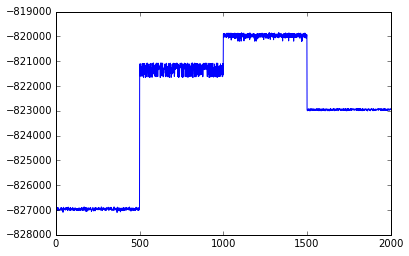

In [60]:
lp = results_lda['lp__']
plt.plot(lp)

In [61]:
results_phi = results_lda['phi']  

In [62]:
results_phi.shape    # draws, # topics, # words

(2000L, 15L, 4228L)

In [63]:
# Check that probabilities sum up to one
sum(results_phi[1,2,:])   # Correct

0.99999999999999578

In [64]:
import numpy as np

In [65]:
# Average over all draws
topics_by_words = np.sum(results_phi,axis=0)

In [66]:
topic_per_word = np.argmax(topics_by_words,0) # most likely topic of each word. Note, topic indexing starts from zero.

In [67]:
# Or average over the best chain only
results_phi_red = results_phi[1000:1500,:,:]

In [68]:
results_phi_red.shape    # 15 topics, 4228 words

(500L, 15L, 4228L)

In [69]:
# Or, pick solution maximising likelihood of the model
idx_max = np.where(lp==max(lp))[0][0]  

In [70]:
lp[idx_max]

-819845.70453189779

In [71]:
idx_max

1331

In [72]:
result_phi_best = results_phi[idx_max,:,:]

In [73]:
topics_by_words_red = np.sum(results_phi_red,axis=0)
topic_per_word_red = np.argmax(topics_by_words_red,0) 

In [74]:
topics_by_words_best = result_phi_best   # what if instead of summing you pick max solution? 
topic_per_word_best = np.argmax(topics_by_words_best,0) 

In [75]:
topics_by_words_best.shape

(15L, 4228L)

In [76]:
topic_per_word[0:10]

array([11, 11, 11, 11,  7,  7,  7, 10,  7,  7], dtype=int64)

In [77]:
topic_per_word_red[0:10]

array([ 1,  1,  1,  7, 10, 10, 10, 10, 10, 10], dtype=int64)

In [78]:
topic_per_word_best[0:10]

array([ 1,  1,  1,  7, 10, 10, 10, 10, 10, 10], dtype=int64)

In [79]:
float(len(np.where(topic_per_word_best!=topic_per_word_red)[0]))/len(topic_per_word_best)  # the two are very similar

0.0510879848628193

In [80]:
len(np.where(topic_per_word_best==14)[0])

80

In [81]:
len(topic_per_word_best)

4228

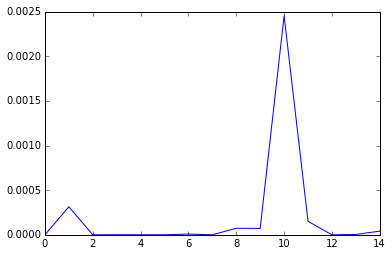

In [26]:
plt.plot(topics_by_words_best[:,20])

In [10]:
# Import labels of each word
# fids = []
# with open('results/word_dict.csv','r') as infile:
#     for line in infile:
#         fids.append(line.rstrip())

In [26]:
import pandas as pd

In [27]:
# Import labels of each word
X = np.genfromtxt('../data/paths_all.csv', delimiter=',')   # matrix [n_segments, n_journeys] storing how many times each segment was visited in each journey
vocab = pd.DataFrame.from_csv("../data/ITN_data.csv")["fid_1"].tolist()  # list with street segment ids

In [28]:
len(vocab)

5290

In [29]:
temp = np.where(X>0)
words = temp[1][0:5000]

In [30]:
np.unique(words)

array([   3,    4,   29, ..., 5275, 5283, 5285], dtype=int64)

In [31]:
temp

(array([   0,    0,    0, ..., 5504, 5504, 5504], dtype=int64),
 array([ 106,  283,  305, ..., 4465, 4691, 4692], dtype=int64))

* Import label for each word

In [56]:
# Import labels of each word
fids = []
with open("results/word_dict_cont_first100000.csv",'r') as infile:
    for line in infile:
        fids.append(line.rstrip())

In [95]:
len(fids)

4228

* Or reuse labels from running results 

In [32]:
# Converted to true ids
converted_to_true_ids = {}
for true, converted in true_to_converted_ids.iteritems():    # Note: true_to_converted_ids is different for cont and real data
    converted_to_true_ids[converted] = true

NameError: name 'true_to_converted_ids' is not defined

In [242]:
words

array([ 106,  283,  305, ..., 2740, 2829, 2892], dtype=int64)

In [301]:
fids = [vocab[converted_to_true_ids[i]] for i in np.unique(words_conv)]

* Finished importing word labels

In [82]:
# Store assignments in a dictionary
fid_topics = dict(zip(fids,topic_per_word_best))

In [97]:
fid_topics.items()[0]

('osgb4000000030990626', 8)

* Export results

In [101]:
# Export fid_topics
with open('results/results_ldatb_cont_first100000_topics15.csv','w') as outfile:
    outfile.write('fid,topics\n')
    for fid, topic in fid_topics.iteritems():
        outfile.write(fid+','+str(topic)+'\n')

In [83]:
len(topic_per_word_best)

4228

In [84]:
len(np.where(topic_per_word_best==0)[0])     #Very small topics: 4,5,6,8,9,10,11,12,13,14

202

* Plot results

In [85]:
# Plot results
import igraph as ig

In [86]:
# Load undirected graph
tobys_dir = '../data/itn directed network from toby/'
g = ig.load(tobys_dir + 'camden_buff100_physical.graphml')

In [87]:
from cPickle import load, dump
with open(tobys_dir + 'camden_buff100_node_positions.pkl','r') as infile:
    node_positions = load(infile)
with open(tobys_dir + 'camden_buff100_edge_polylines_kira.pkl','r') as infile:
    edge_polylines = load(infile)

In [88]:
# Add x,y to nodes
for vertex in g.vs:
    fid = vertex['id']
    vertex['x'] = node_positions[fid][0]
    vertex['y'] = -node_positions[fid][1]

In [89]:
pal = ig.RainbowPalette(n=len(np.unique(topic_per_word_best)),s=1,v=0.9)

In [90]:
pal_cols = [pal[i] for i in range(0,len(pal))]

In [91]:
# Shuffle topic numbers
import random
topics_shuffled = np.unique(topic_per_word_best)
random.shuffle(topics_shuffled)

In [92]:
#topics_selected = [0,3,6,9,11,12,13]

topics_selected = [13]
# Assign color to each edge     Topics: 0,3,6,9,11,12,13
for edge in g.es:
    fid = edge['fid']
    if fid in fid_topics:
        col_idx = fid_topics[fid]
        if col_idx in topics_selected:
            edge['color'] = pal_cols[col_idx]
            #edge['color'] = 'red'
            edge['width'] = 4
        else:
            edge['color'] = (0.7450980392156863, 0.7450980392156863, 0.7450980392156863, 0.5)
            edge['width'] = 0    #1
          
#         if col_idx<9:
#             edge['color'] = pal_cols[topics_shuffled[col_idx]]
#             edge['width'] = 1.5
#         else:
#             edge['color'] = (0.7450980392156863, 0.7450980392156863, 0.7450980392156863, 0.5)
#             edge['width'] = 0.5

#         edge['color'] = pal_cols[col_idx]
#         edge['width'] = 4
    else:
        edge['color'] = (0.7450980392156863, 0.7450980392156863, 0.7450980392156863, 0.5)
        edge['width'] = 0     #0.5


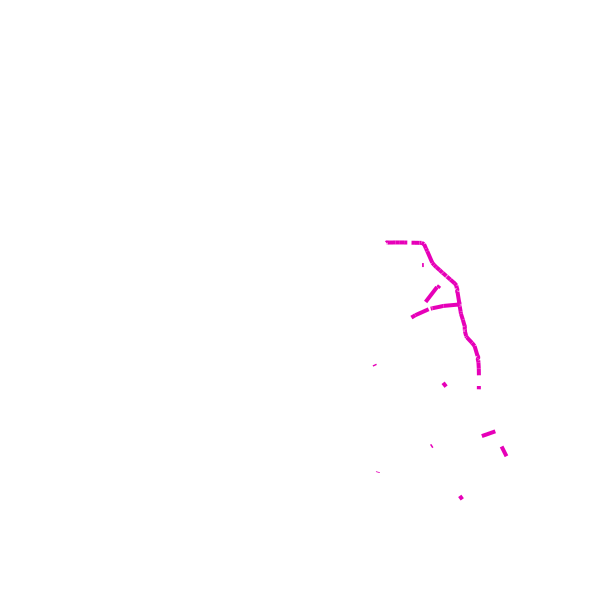

In [93]:
ig.plot(g,vertex_size=0)     # topics from 9 onwards are very messy, perhaps, remove them from plots.

In [94]:
plot = ig.plot(g,vertex_size=0,bbox=(2000,2000))
plot.background = None
plot.redraw()

In [91]:
plot.save('topics15_ldatb_cont_first100000_topic13.png')

## Apply models to 2010 vehicle data

In [33]:
import numpy as np
import pandas as pd

In [34]:
# Import data
X = np.genfromtxt('../data/paths_all.csv', delimiter=',')   # matrix [n_segments, n_journeys] storing how many times each segment was visited in each journey

In [35]:
print X.shape # 5290 street segments, 5505 journeys

(5505L, 5290L)


In [36]:
vocab = pd.DataFrame.from_csv("../data/ITN_data.csv")["fid_1"].tolist()  # list with street segment ids
titles = range(1,5291) # each journey is assigned an integer

In [37]:
# Prepare data for LDA
temp = np.where(X>0)

In [38]:
docs = temp[0]+1

In [39]:
words = temp[1]

In [40]:
len(words)

266308

In [41]:
# Reduce the size of the data
docs = docs[0:100000]
words = words[0:100000]

In [42]:
min(words)

0

In [43]:
len(np.unique(words))

4362

In [44]:
# Convert segment numbers to start from 1 (and store labels for future reference)
true_ids = np.unique(words)
true_to_converted_ids = {} # dictionary storing the mapping from actual segment numbers to their converted equivalents
fids = []

for i, true_id in enumerate(true_ids):
    true_to_converted_ids[true_id] = i+1
    fids.append(vocab[true_id])

In [45]:
fids

['osgb4000000030101703',
 'osgb4000000030147329',
 'osgb4000000030153160',
 'osgb4000000030239173',
 'osgb4000000030250491',
 'osgb4000000030329965',
 'osgb4000000030344319',
 'osgb4000000030355054',
 'osgb4000000030425142',
 'osgb4000000030425145',
 'osgb4000000030703925',
 'osgb4000000030704291',
 'osgb4000000030704292',
 'osgb4000000030704294',
 'osgb4000000030704726',
 'osgb4000000030704774',
 'osgb4000000030704775',
 'osgb4000000030872443',
 'osgb4000000030872451',
 'osgb4000000030872459',
 'osgb4000000030872468',
 'osgb4000000030872470',
 'osgb4000000030999468',
 'osgb4000000031284590',
 'osgb4000000030139356',
 'osgb4000000030223481',
 'osgb4000000030250528',
 'osgb4000000031284854',
 'osgb4000000030147364',
 'osgb4000000030147365',
 'osgb4000000030147369',
 'osgb4000000030238921',
 'osgb4000000030239195',
 'osgb4000000030239199',
 'osgb4000000030239543',
 'osgb4000000030344320',
 'osgb4000000030344322',
 'osgb4000000030860723',
 'osgb4000000030138934',
 'osgb4000000031213472',


In [60]:
# Export word labels
with open('results/word_dict_real_first100000.csv','w') as outfile:
    for fid in fids:
        outfile.write(fid+'\n')

In [187]:
# Use converted ids to prepare LDA 'words' input
words_conv = []
for true_id in words:
    words_conv.append(true_to_converted_ids[true_id])

In [185]:
no_topics = 15
no_words = len(np.unique(words_conv))
no_docs = len(np.unique(docs))
lda_data4 = {'K':no_topics,'V':no_words,'M':no_docs,'N':len(words_conv),
'w': words_conv,
'doc': docs,
'alpha': list((1./no_topics)*np.ones(no_topics)),'beta': list((1./no_words)*np.ones(no_words))}

In [75]:
fit4 = pystan.stan(model_code=lda_code, data=lda_data4, iter=1000, chains=4)
results_lda2 = fit4.extract(permuted=True) 
from cPickle import dump, load
with open("results/results_real_first100000.pkl", "wb") as f:
    dump(results_lda2, f)

/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The re

In [73]:
??pystan.stan

* Run lda-tb

In [46]:
# Inputs
# All as before except t: Not really, you need sequence data...

In [47]:
# Import *continuous* journey sequences
datadir = '../data/police journeys continuous/'

In [48]:
import os
journey_files = os.listdir(datadir)

In [49]:
fids = []    # list for storing visited fids
words = []
docs = []
for journey_file in journey_files:
    if journey_file[0]!='.':
        journey_no = int(journey_file.strip('.csv').strip('journey'))
        with open(datadir+journey_file,'r') as infile:
            for line in infile:
                docs.append(journey_no)
                fid = line.rstrip()
                if fid in fids:
                    words.append(fids.index(fid)+1)   # pyStan numbering starts from 1
                else:
                    fids.append(fid)
                    words.append(fids.index(fid)+1)

In [50]:
# Sort docs (at the moment the order is 1, 10, 100 etc...)
words_sorted = []
docs_sorted = []

for doc_no in np.unique(docs):
    indices = np.where(np.asarray(docs)==doc_no)[0]
    
    for idx in indices:
        docs_sorted.append(doc_no)
        words_sorted.append(words[idx])
    
# words_sorted = [word for (doc,word) in sorted(zip(docs,words))]  # this appraoch mixed them a bit
# docs_sorted = [doc for (doc,word) in sorted(zip(docs,words))]

KeyboardInterrupt: 

In [408]:
# Import *physcial* street network to get connectivity information

# Load undirected graph
tobys_dir = '../data/itn directed network from toby/'
g = ig.load(tobys_dir + 'camden_buff100_physical.graphml')

In [301]:
# First attempt, we ignore one-wayness and assume that each road is two-directional (Hence, t should be symmetric)

In [302]:
fids_adjacent_all = []

for fid in fids:
    fids_adjacent = []
    
    edge = g.es.select(fid_eq=fid)[0]
    source = edge.source
    target = edge.target
    ends = [source, target]
    
    for fid2 in fids:
        if fid2 != fid:
            edge2 = g.es.select(fid_eq=fid2)[0]
            if edge2.source in ends or edge2.target in ends:
                fids_adjacent.append(fid2)
    fids_adjacent_all.append(fids_adjacent)

In [326]:
t = np.zeros(shape=(len(fids),len(fids)))

for i, fids_adj in enumerate(fids_adjacent_all):
    for fid in fids_adj:
        j = fids.index(fid)
        t[i,j]=1.0

In [327]:
# Make sure that rows of t sum up to one
row_sums = sum(t,0)

In [331]:
t_norm = np.array(t)
for i,row in enumerate(t_norm):
    t_norm[i,:] = t_norm[i,:]/row_sums[i]

In [336]:
# Add ones to the diagonal
np.fill_diagonal(t_norm, 1)

In [409]:
# Export inputs and word labels
from cPickle import load, dump

In [410]:
with open("results/words_cont.pkl", "wb") as f:
    dump(words_sorted, f)
with open("results/docs_cont.pkl", "wb") as f:
    dump(docs_sorted, f)
with open("results/docs_cont.pkl", "wb") as f:
    dump(docs_sorted, f)

In [413]:
# Export t and fids for future reference
with open('results/word_dict_cont.csv','w') as outfile:
    for fid in fids:
        outfile.write(fid+'\n')

In [419]:
# Subset only the first 100,000 words for initial analysis
docs = docs_sorted[0:100000]
words = words_sorted[0:100000]

In [429]:
# Convert segment numbers to start from 1 (and store labels for future reference)
true_ids = np.unique(words)
true_to_converted_ids = {} # dictionary storing the mapping from actual segment numbers to their converted equivalents
fids_new = []

for i, true_id in enumerate(true_ids):
    true_to_converted_ids[true_id] = i+1
    fids_new.append(fids[true_id-1])

In [431]:
words_conv = []
for true_id in words:
    words_conv.append(true_to_converted_ids[true_id])

In [542]:
# Create a subset of t (but with the same properties: diagonals, row sums :))
t_new = t[np.array(true_ids-1).reshape(-1,1),(true_ids-1)]

In [549]:
# Make sure that rows of t_new sum up to one
row_sums = sum(t_new,0)

In [550]:
t_new_norm = np.array(t_new)
for i,row in enumerate(t_new):
    t_new_norm[i,:] = t_new[i,:]/row_sums[i]

In [563]:
# Add ones to the diagonal
np.fill_diagonal(t_new_norm, 1)

In [576]:
# Export results
with open("results/words_cont_first100000.pkl", "wb") as f:
    dump(words_conv, f)
with open("results/docs_cont_first100000.pkl", "wb") as f:
    dump(docs, f)
with open("results/t_cont_first100000.pkl", "wb") as f:
    dump(t_new_norm, f)

In [579]:
with open('results/word_dict_cont_first100000.csv','w') as outfile:
    for fid in fids_new:
        outfile.write(fid+'\n')

In [6]:
# Run lda-tb
from cPickle import load
import numpy as np

In [67]:
with open('results/words_cont_first100000.pkl','r') as infile:
    words = load(infile)
with open("results/docs_cont_first100000.pkl",'r') as infile:
    docs = load(infile)
with open("results/t_cont_first100000.pkl", 'r') as infile:
    t = load(infile)

In [70]:
# Preprocess t: (1) you cannot have zeros as they lead to -Inf log likelihoods; (2) t should be a list.
t[np.where(t==0)]=0.00000000001

In [85]:
no_topics = 15
no_words = len(np.unique(words))
no_docs = len(np.unique(docs))
lda_tb_data = {'K':no_topics,'V':no_words,'M':no_docs,'N':len(words),
'w': words,
'doc': docs,
'alpha': list((1./no_topics)*np.ones(no_topics)),'beta': list((1./no_words)*np.ones(no_words)),'t':list(t)}

In [86]:
fit = pystan.stan(model_code=lda_tb_code, data=lda_tb_data, iter=1000, chains=4,init=myinit)
results_lda_tb = fit.extract(permuted=True) 
from cPickle import dump, load
with open("results/results_ldatb_cont_first100000.pkl", "wb") as f:
    dump(results_lda_tb, f)

/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/kirakowalska/anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The re

In [ ]:
# Perhaps double-check continuity of words?

In [58]:
## Initialization function
import random
def myinit():
    
    temp = np.random.rand(no_topics,no_words)
    phi = np.transpose(np.transpose(temp)/np.sum(temp,1))

    temp = np.random.rand(no_docs,no_topics)
    theta = np.transpose(np.transpose(temp)/np.sum(temp,1))
    
    params={}
    params['theta']=theta
    params['phi']=phi
    
    return params

In [2]:
lda_tb_code = """
data {
  int<lower=2> K;               // num topics
  int<lower=2> V;               // num words (distinct)
  int<lower=1> M;               // num docs
  int<lower=1> N;               // total word instances
  int<lower=1,upper=V> w[N];    // word n
  int<lower=1,upper=M> doc[N];  // doc ID for word n
  vector<lower=0>[K] alpha;     // topic prior
  vector<lower=0>[V] beta;      // word prior
  matrix[V,V] t;
}
parameters {
  simplex[K] theta[M];   // topic dist for doc m
  simplex[V] phi[K];     // word dist for topic k
}
model {
  for (m in 1:M)  
    theta[m] ~ dirichlet(alpha);  // prior
  for (k in 1:K)  
    phi[k] ~ dirichlet(beta);     // prior
    
  for (n in 1:N) {
    real gamma[K];
    for (k in 1:K) 
      gamma[k] <- log(theta[doc[n],k]) + log(phi[k,w[n]]) + log(t[w[max(n-1,1)],w[n]]);
    increment_log_prob(log_sum_exp(gamma));  // likelihood
  }
}
"""

In [37]:
lda_code = """
data {
  int<lower=2> K;               // num topics
  int<lower=2> V;               // num words (distinct)
  int<lower=1> M;               // num docs
  int<lower=1> N;               // total word instances
  int<lower=1,upper=V> w[N];    // word n
  int<lower=1,upper=M> doc[N];  // doc ID for word n
  vector<lower=0>[K] alpha;     // topic prior
  vector<lower=0>[V] beta;      // word prior
}
parameters {
  simplex[K] theta[M];   // topic dist for doc m
  simplex[V] phi[K];     // word dist for topic k
}
model {
  for (m in 1:M)  
    theta[m] ~ dirichlet(alpha);  // prior
  for (k in 1:K)  
    phi[k] ~ dirichlet(beta);     // prior
  for (n in 1:N) {
    real gamma[K];
    for (k in 1:K) 
      gamma[k] <- log(theta[doc[n],k]) + log(phi[k,w[n]]);
    increment_log_prob(log_sum_exp(gamma));  // likelihood
  }
}
"""

## Plotting any LDA results

#### Plot spatial distribution of topics

In [169]:
#results = 'results/results_ldatb_cont_first100000_topics15.csv'
# results = '../../functional_regions/results/street_by_topic10.csv'
# results = '../../functional_regions/results/street_by_topic150.csv'
results = '../../functional_regions/results/street_by_comdef2.csv'

In [170]:
# Import fid topics (assignment of topics to fids)
fid_topics = dict()
with open(results,'r') as infile:
    next(infile)
    for line in infile:
        fid,topic = line.rstrip().split(',')
        fid_topics[fid]=int(topic)

In [171]:
# Make sure that community numbering increases by one

# If the top number exceeds the number of unique communities:
if np.max(list(fid_topics.values()))>len(np.unique(list(fid_topics.values()))):
    
    fid_topics_ordered = dict()
    com_to_com_ordered = dict(zip(np.unique(list(fid_topics.values())),range(0,len(np.unique(list(fid_topics.values()))))))

    for fid, com in fid_topics.items():
        fid_topics_ordered[fid] = com_to_com_ordered[com]
    
    fid_topics = fid_topics_ordered

In [172]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import igraph as ig

# Load undirected graph
tobys_dir = '../data/itn directed network from toby/'
g = ig.load(tobys_dir + 'camden_buff100_physical.graphml')

from pickle import load
with open(tobys_dir + 'camden_buff100_node_positions.pkl','rb') as infile:
    node_positions = load(infile, encoding='latin1')
with open(tobys_dir + 'camden_buff100_edge_polylines_kira.pkl','rb') as infile:
    edge_polylines = load(infile, encoding='latin1')

# Add x,y to nodes
for vertex in g.vs:
    fid = vertex['id']
    vertex['x'] = node_positions[fid][0]
    vertex['y'] = -node_positions[fid][1]

pal = ig.RainbowPalette(n=len(np.unique(list(fid_topics.values()))),s=1,v=0.9)
pal_cols = [pal[i] for i in range(0,len(pal))]

topics_selected= list(fid_topics.values())
#topics_selected = [0,3,6,9,11,12,13]   # only for lda-tb results
#topics_selected = [13]
# Assign color to each edge     
for edge in g.es:
    fid = edge['fid']
    if fid in fid_topics:
        col_idx = fid_topics[fid]
        if col_idx in topics_selected:
            edge['color'] = pal_cols[col_idx]
            #edge['color'] = 'red'
            edge['width'] = 4
        else:
            edge['color'] = (0.7450980392156863, 0.7450980392156863, 0.7450980392156863, 0.5)
            edge['width'] = 1    #1
    else:
        edge['color'] = (0.7450980392156863, 0.7450980392156863, 0.7450980392156863, 0.5)
        edge['width'] = 0     #0.5


plot = ig.plot(g,vertex_size=0,bbox=(2000,2000))
plot.background = None
plot.redraw()
plot.show()

#### Plot the distribution of the sizes (nodes as well as edges, possibly fractions of the entire sets) of the communities

In [173]:
import seaborn as sns

In [174]:
from collections import Counter

In [175]:
topic_sizes = dict(Counter(list(fid_topics.values())))

In [176]:
topic_sizes_norm = dict()
for key,value in topic_sizes.items():
    if value>=5 and value<1000:
        topic_sizes_norm[key]=value

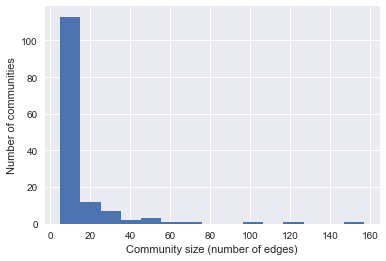

In [177]:
plt.hist(list(topic_sizes_norm.values()),bins=15)
plt.xlabel('Community size (number of edges)')
plt.ylabel('Number of communities')      # how many do we want?

plt.savefig('results/'+results.split('/')[-1].rstrip('.csv')+'_sizehist.png',dpi=500)

#### Compute mutual information score for all communities

In [178]:
from sklearn.metrics import adjusted_mutual_info_score

* Import all results

In [182]:
edges = list(fid_topics.keys())

In [219]:
labels_all = ['spatial topics (K=15)','topics (K=10)','topics (K=150)','communities','spatial communities']
results_all = ['results/results_ldatb_cont_first100000_topics15.csv','../../functional_regions/results/street_by_topic10.csv',
              '../../functional_regions/results/street_by_topic150.csv','../../functional_regions/results/street_by_comdef1.csv',
              '../../functional_regions/results/street_by_comdef2.csv']
fid_topics_ordered_all = dict()
for i,results in enumerate(results_all):
    fid_topics = dict()
    with open(results,'r') as infile:
        next(infile)
        for line in infile:
            fid,topic = line.rstrip().split(',')
            fid_topics[fid]=int(topic) 
    fid_topics_ordered = []
    for edge in edges:
        try:
            fid_topics_ordered.append(fid_topics[edge])
        except:
            print('Edge not found: ' + str(edge))
            fid_topics_ordered.append(0)
    fid_topics_ordered_all[labels_all[i]]=fid_topics_ordered

Edge not found: osgb4000000030330140
Edge not found: osgb4000000030455321
Edge not found: osgb4000000030344221
Edge not found: osgb4000000031063543
Edge not found: osgb4000000030455449
Edge not found: osgb4000000030330306
Edge not found: osgb4000000030330274
Edge not found: osgb4000000030239011
Edge not found: osgb4000000030708469
Edge not found: osgb4000000031200476
Edge not found: osgb4000000030344740
Edge not found: osgb4000000030411177
Edge not found: osgb4000000030990727
Edge not found: osgb4000000031252080
Edge not found: osgb4000000030343856
Edge not found: osgb4000000031200447
Edge not found: osgb4000000030872472
Edge not found: osgb4000000030419373
Edge not found: osgb4000000030238887
Edge not found: osgb4000000030411274
Edge not found: osgb4000000030343836
Edge not found: osgb4000000030329941
Edge not found: osgb4000000030344823
Edge not found: osgb4000000030344211
Edge not found: osgb4000000030344362
Edge not found: osgb4000000031200483
Edge not found: osgb4000000031186702
E

In [220]:
mutual_info_scores = np.zeros(shape=(len(labels_all),len(labels_all)))

for i,label_i in enumerate(labels_all):
    for j, label_j in enumerate(labels_all):
        mutual_info_scores[i,j]=adjusted_mutual_info_score(fid_topics_ordered_all[label_i],fid_topics_ordered_all[label_j])

/Users/kirakowalska/eb-virt/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


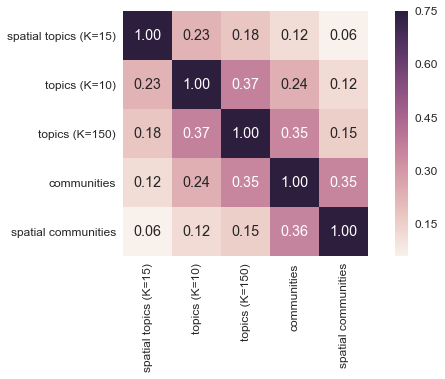

In [232]:
# from matplotlib import rcParams
# rcParams.update({'figure.autolayout': True})
sns.set(font_scale=1.2) 
sns.heatmap(mutual_info_scores, vmax=.75, square=True, annot=True, fmt='.2f',xticklabels=labels_all,yticklabels=labels_all)
# plt.tight_layout()
plt.savefig('results/mutual_info_score.png',dpi=500)

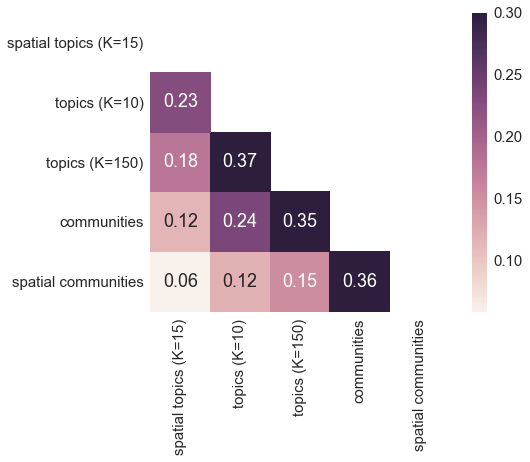

In [222]:
mask = np.zeros_like(mutual_info_scores)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(mutual_info_scores, mask=mask, vmax=.3, square=True, annot=True, fmt='.2f',xticklabels=labels_all,yticklabels=labels_all)